# Donorchose.org empowers public school teachers from across the country to request much-needed materials and experiences for their students.
At any given time, there are thousands of classroom requests that can be brought to life with a gift of any amount.

In this notebook we solve the problem whether the teacher gets the approval or not.


Business constraints:
1.No latency issue
2.AUC as the metric(as imbalanced dataset)


In [1]:
import pandas as pd
import pylab as pl # linear algebra + plots
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import gc
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score as auc
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict, Counter
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import TextBlob
from scipy.stats import pearsonr
from scipy.sparse import hstack
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
import string
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('trainschool.csv')

In [3]:
df.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1


In [4]:
#resources data
rc=pd.read_csv('resources.csv')

In [5]:
rc.head()

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


Exploratory Data Analysis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182080 entries, 0 to 182079
Data columns (total 16 columns):
id                                              182080 non-null object
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null object
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                        

In [7]:
#Little description of training data for numerical features

In [8]:
df.describe()

,teacher_number_of_previously_posted_projects,project_is_approved
count,182080.000000,182080.000000
mean,11.237055,0.847682
std,28.016086,0.359330
min,0.000000,0.000000
25%,0.000000,1.000000
50%,2.000000,1.000000
75%,9.000000,1.000000
max,451.000000,1.000000


In [9]:
#desciption for categorical featues

In [10]:
df.describe(include=["O"])

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary
count,182080,182080,182076,182080,182080,182080,182080,182080,182080,182080,182080,6374,6374,182080
unique,182080,104414,5,51,180439,4,51,407,164282,147689,180984,6359,6336,179730
top,p082520,fa2f220b537e8653fb48878ebb38044d,Mrs.,CA,2016-09-01 00:00:03,Grades PreK-2,Literacy & Language,Literacy,Flexible Seating,As a teacher in a low-income/high poverty scho...,Students will be using Chromebooks to increase...,We will use the wobble chairs to provide non-t...,"Having taught engineering in college, I have c...",My students need electronic tablets to do all ...
freq,1,74,95405,25695,30,73890,39257,15775,377,46,24,2,3,84


In [11]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
project_essay_4,175706,96.499341
project_essay_3,175706,96.499341
teacher_prefix,4,0.002197
project_is_approved,0,0.000000
teacher_number_of_previously_posted_projects,0,0.000000


In [12]:
##96% of the values in essay 4 and essay 3 are missing.

In [13]:
rc.describe()

,quantity,price
count,1.541272e+06,1.541272e+06
mean,2.860509e+00,5.028398e+01
std,7.570345e+00,1.447326e+02
min,1.000000e+00,0.000000e+00
25%,1.000000e+00,7.900000e+00
50%,1.000000e+00,1.499000e+01
75%,2.000000e+00,3.980000e+01
max,8.000000e+02,9.999000e+03


In [14]:
#no of points
df.shape[0]

182080

In [15]:
#no of features
df.shape[1]

16

In [16]:
#We have around 182K rows in the dataset with 16 columns. 
#Let us first look into the distribution of the target variable "project_is_approved" to understand more about the class imbalance.
df[df['project_is_approved']==1].shape[0]


154346

In [17]:
152346/182080

0.8366981546572935

In [18]:
## imbalanced dataset, thus AUC is the right metric

In [19]:
# analysis of each feature one by one

In [20]:
#project grade feature
# school grade levels distribution

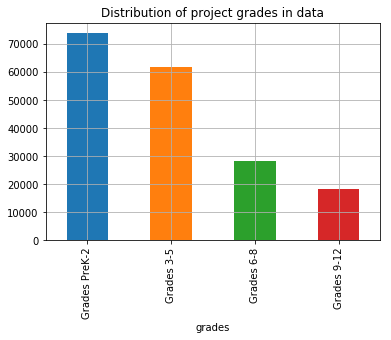

In [21]:
my_colors = 'rgbkymc'
df['project_grade_category'].value_counts().plot(kind='bar')
plt.xlabel('grades')
plt.ylabel('')
plt.title('Distribution of project grades in data')
plt.grid()
plt.show()

In [22]:
#does approved projects depend on grades?
#lets try to see

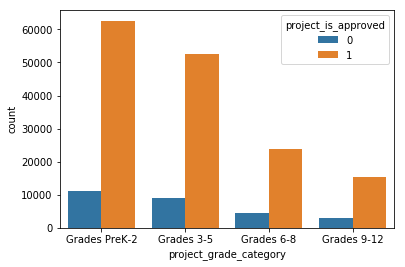

In [23]:
sns.countplot(x='project_grade_category',data=df,hue=df['project_is_approved'])
plt.show()

In [24]:
# most approved projects grades are for gradesprek-2

In [25]:
# most approved projects grades are for gradesprek-2(small children) only and distributiom is same only for both

Gender

In [26]:
##Does approved depends on gender/prefix

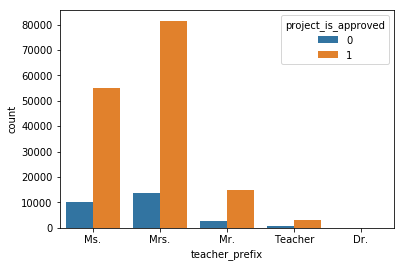

In [27]:
sns.countplot(x='teacher_prefix',data=df,hue='project_is_approved')
plt.show()

In [28]:
## Unsurprisingly, there are more Female teachers. But that does not affect/bias the Approval rate at all.

In [29]:
## Project Subject Category:

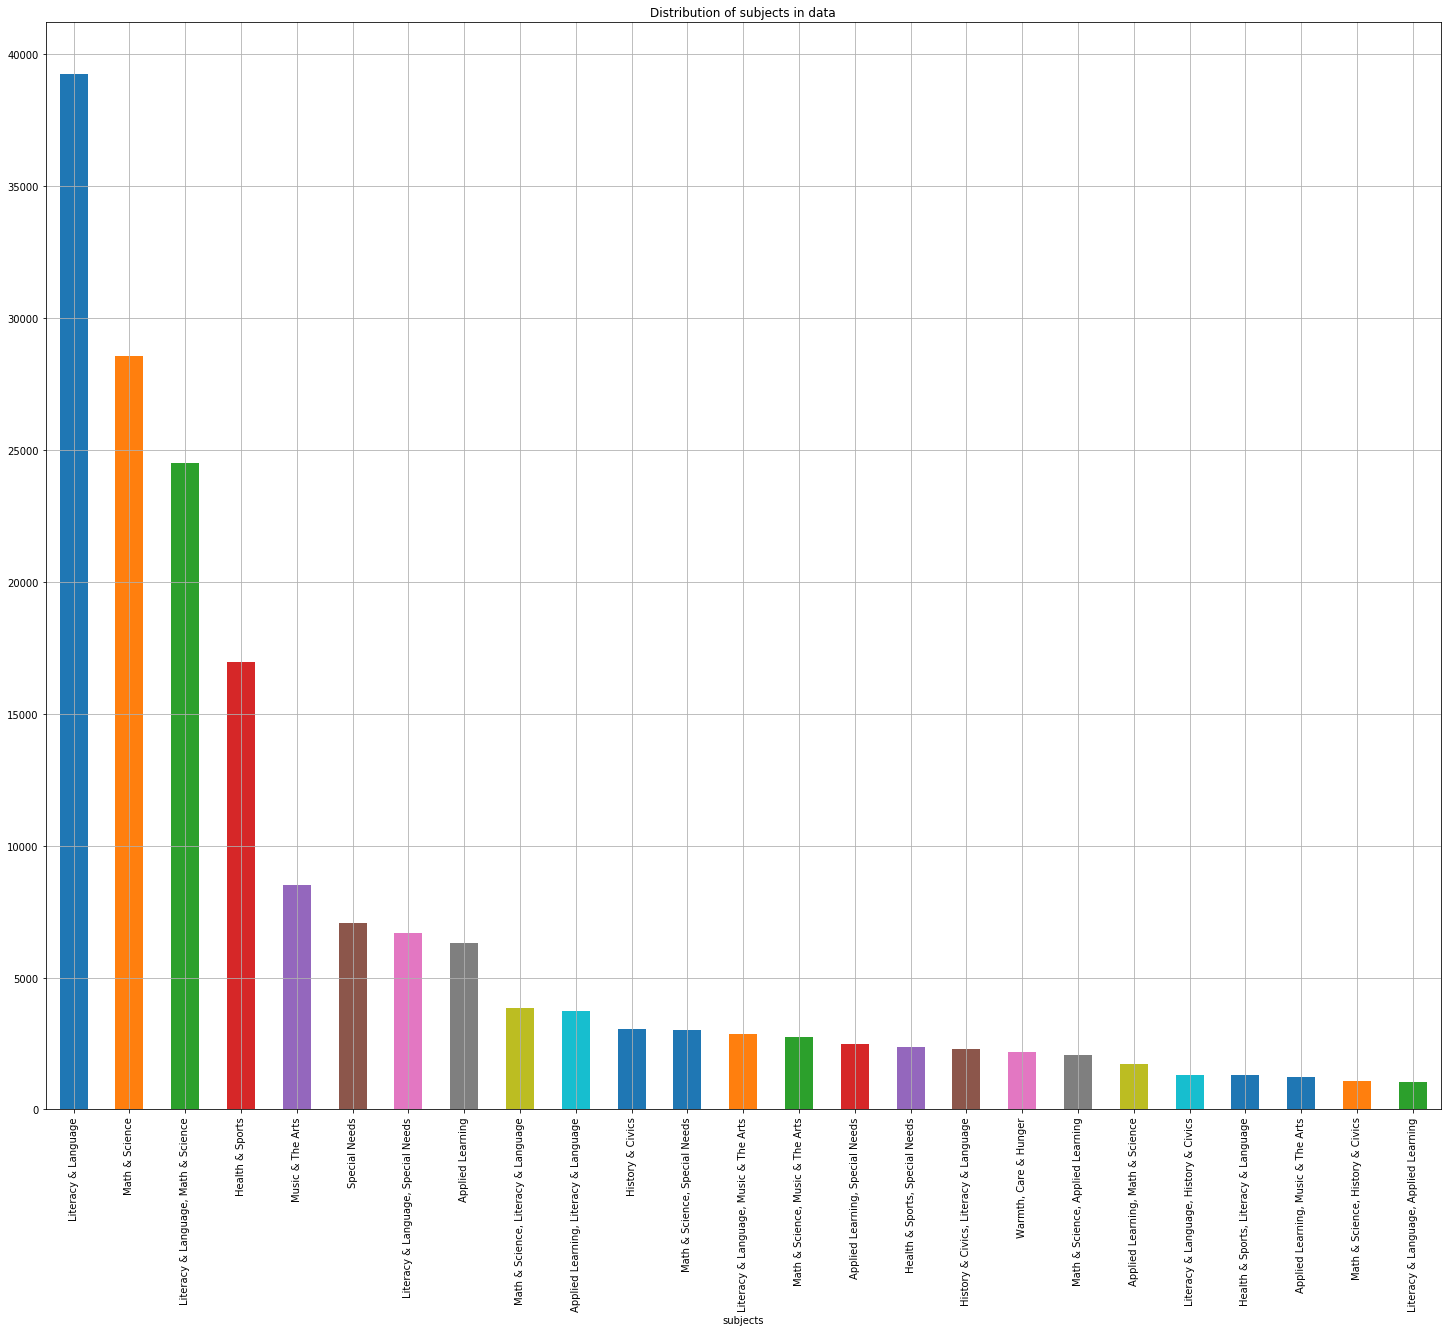

In [30]:
my_colors = 'rgbkymc'
plt.figure(figsize=(25,20))
df['project_subject_categories'].value_counts()[0:25].plot(kind='bar')

plt.xlabel('subjects')
plt.ylabel('')
plt.title('Distribution of subjects in data')
plt.grid()
plt.show()

In [31]:
# literacy and language is the most 

In [32]:
#As seen  literacy and language us also present in the others as well with many others

In [33]:
##Project subject subcategories

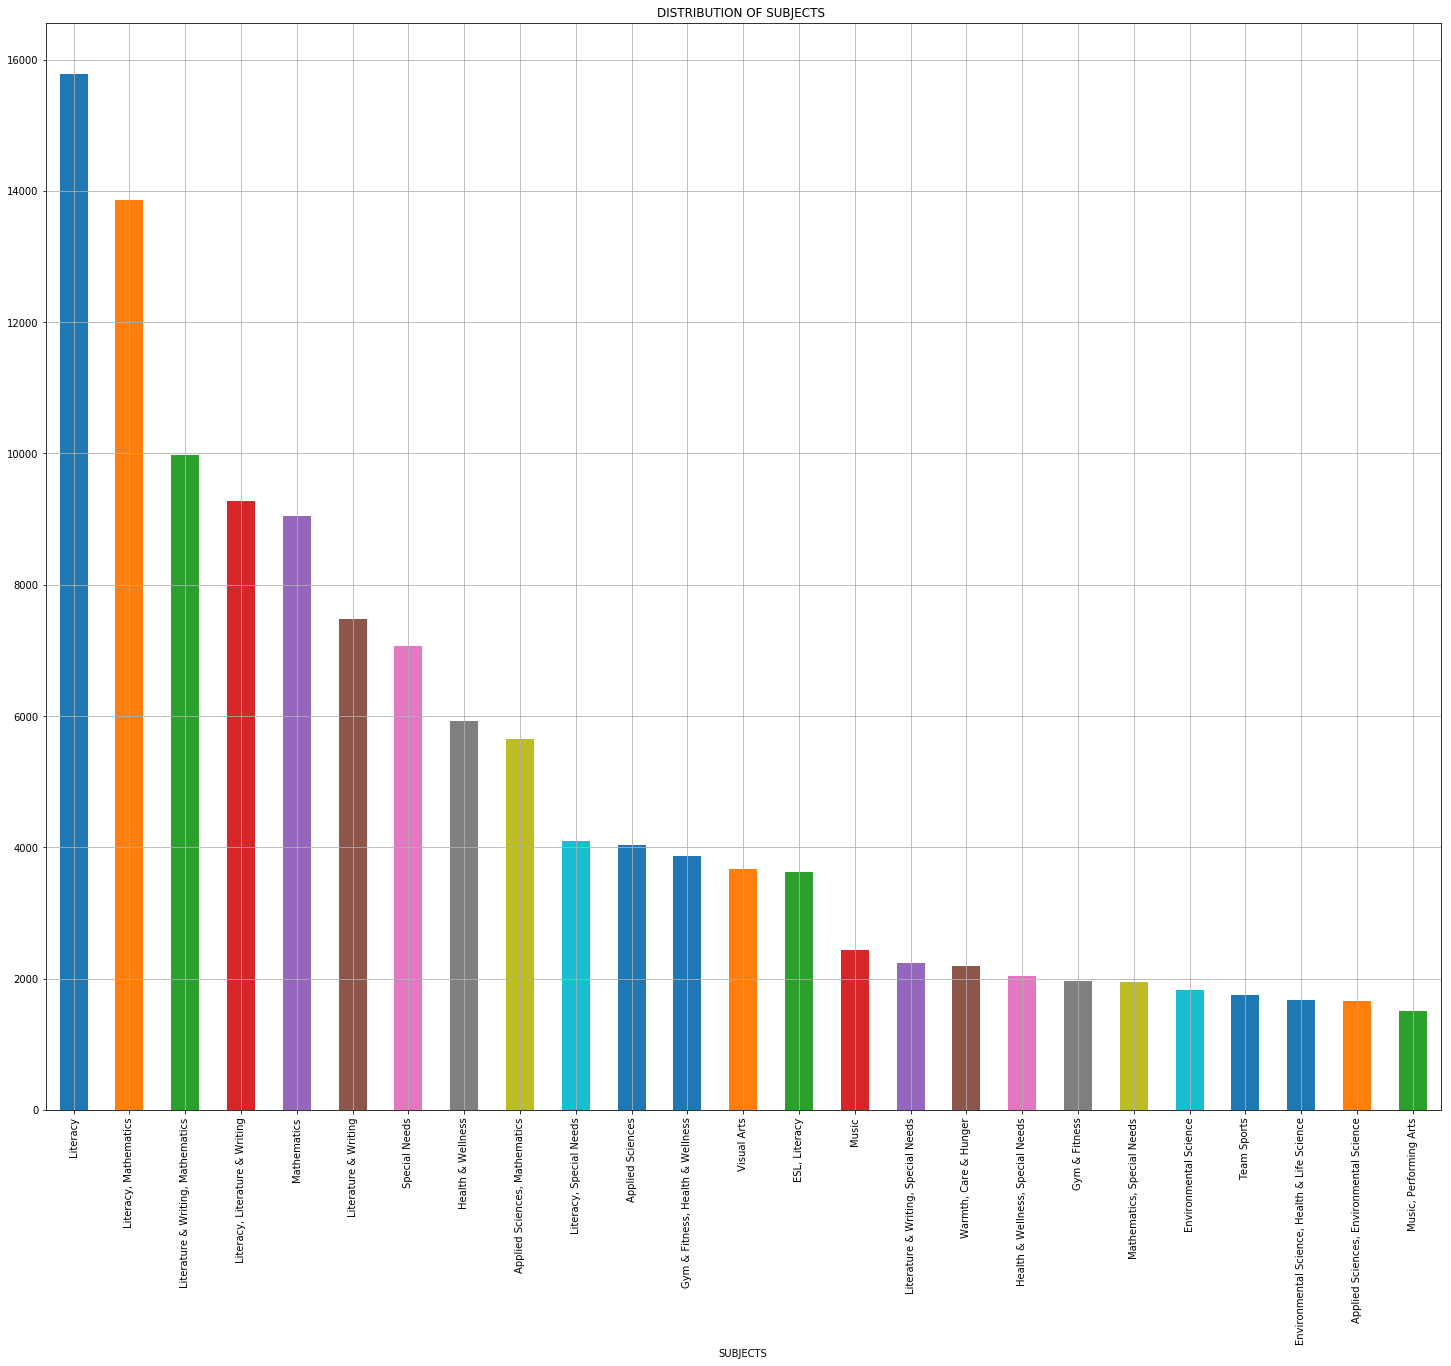

In [34]:
my_colors = 'rgbkymc'
plt.figure(figsize=(25,20))
df['project_subject_subcategories'].value_counts()[0:25].plot(kind='bar')

plt.xlabel('SUBJECTS')
plt.ylabel('')
plt.title('DISTRIBUTION OF SUBJECTS ')
plt.grid()
plt.show()

In [35]:
##Literacy is the most applied 

In [36]:
## Does approval depends on states/country?

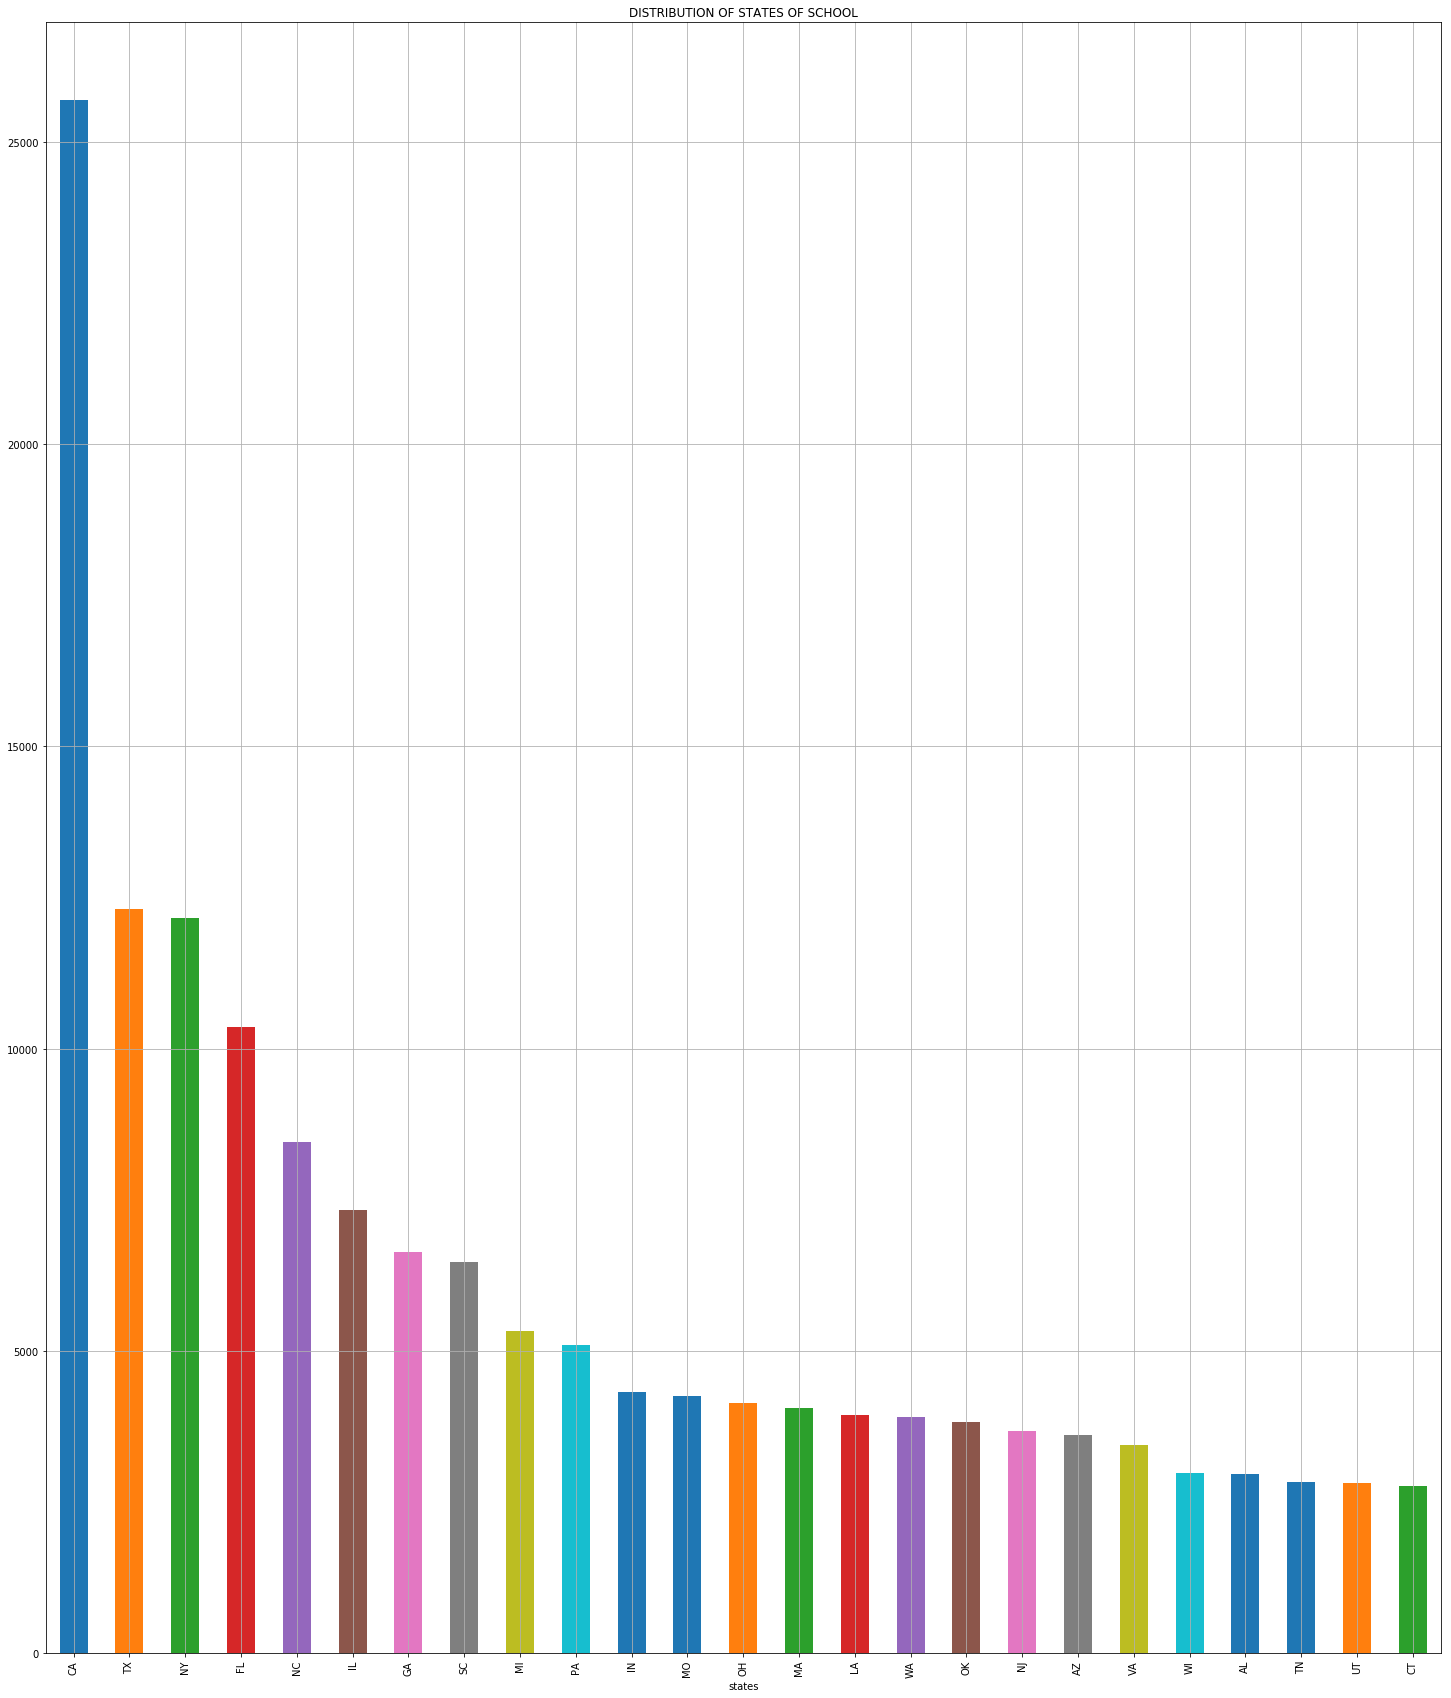

In [37]:
# school state
plt.figure(figsize=(25,30))
df['school_state'].value_counts()[0:25].plot(kind='bar')
plt.xlabel('states')
plt.title('DISTRIBUTION OF STATES OF SCHOOL')
plt.grid()
plt.show()

In [38]:
##California has  mostly applied for projects , with Texas and NY in joint second place.

In [39]:
## can we represent this on US map to get a  clear sense
#Yes we can

In [ ]:
#Cross tabulation

In [268]:
cols = ['teacher_prefix', 'project_is_approved']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[cols[0]], df[cols[1]]).style.background_gradient(cmap = cm)

project_is_approved,0,1
teacher_prefix,,
Dr.,5,21
Mr.,2791,14876
Mrs.,13921,81484
Ms.,10212,54854
Teacher,805,3107


In [269]:
cols = ['teacher_number_of_previously_posted_projects', 'project_is_approved']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[cols[0]], df[cols[1]]).style.background_gradient(cmap = cm)

project_is_approved,0,1
teacher_number_of_previously_posted_projects,,
0,9045,41022
1,4518,22213
2,2776,14461
3,1887,10006
4,1374,7421
5,1062,5871
6,807,4810
7,634,3855
8,553,3303


In [40]:
#Number of previously posted applications by the submitting teacher was Zero(0) having more number of acceptance rate.

Time Features

In [41]:
df['project_submitted_datetime'].head()

0    2016-11-18 14:45:59
1    2017-04-26 15:57:28
2    2017-01-01 22:57:44
3    2016-08-12 15:42:11
4    2016-08-06 09:09:11
Name: project_submitted_datetime, dtype: object

In [42]:
#Date and time are given
#We can extract various features like exact date,time,days(sunday etc).After this we can sort the data according time.
#It might prove to be useful at the later stages.

In [43]:
df=df.sort_values(by=['project_submitted_datetime'])

In [44]:
# extracting datetime features using datetime module 
df["project_submitted_datetime"] = pd.to_datetime(df["project_submitted_datetime"])
df["Year"] = df["project_submitted_datetime"].dt.year
df["Month"] = df["project_submitted_datetime"].dt.month
df['Weekday'] = df['project_submitted_datetime'].dt.weekday
df["Hour"] = df["project_submitted_datetime"].dt.hour
df["Month_Day"] = df['project_submitted_datetime'].dt.day
df["Year_Day"] = df['project_submitted_datetime'].dt.dayofyear

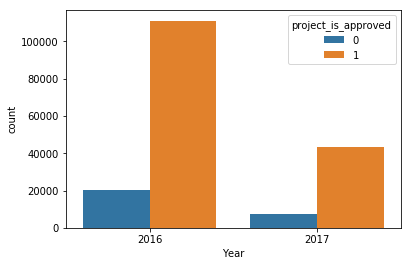

In [45]:
sns.countplot(x='Year',data=df,hue="project_is_approved")

In [47]:
# majorly dates are of 2016 and some are of 2017

In [46]:
#Distribution according to months

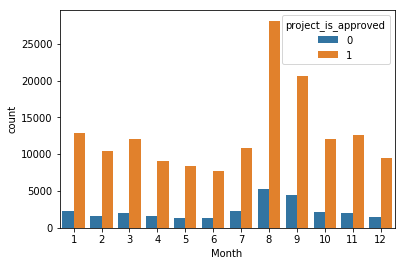

In [48]:
sns.countplot(x='Month',data=df,hue="project_is_approved")


In [49]:
#August has the highest no of requests followed by September

In [50]:
#Weeekday distibution

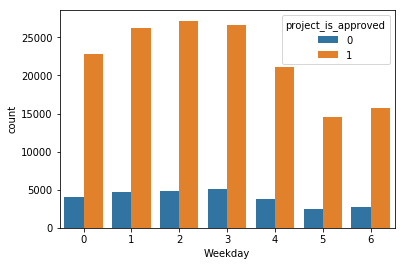

In [51]:
sns.countplot(x='Weekday',data=df,hue="project_is_approved")

In [52]:
##Wednesday has highest no of requests

In [53]:
df["Year_Day"][0:5]

128730    118
173035    118
7344      118
180523    118
8393      118
Name: Year_Day, dtype: int64

In [54]:
#Days of Year distribution

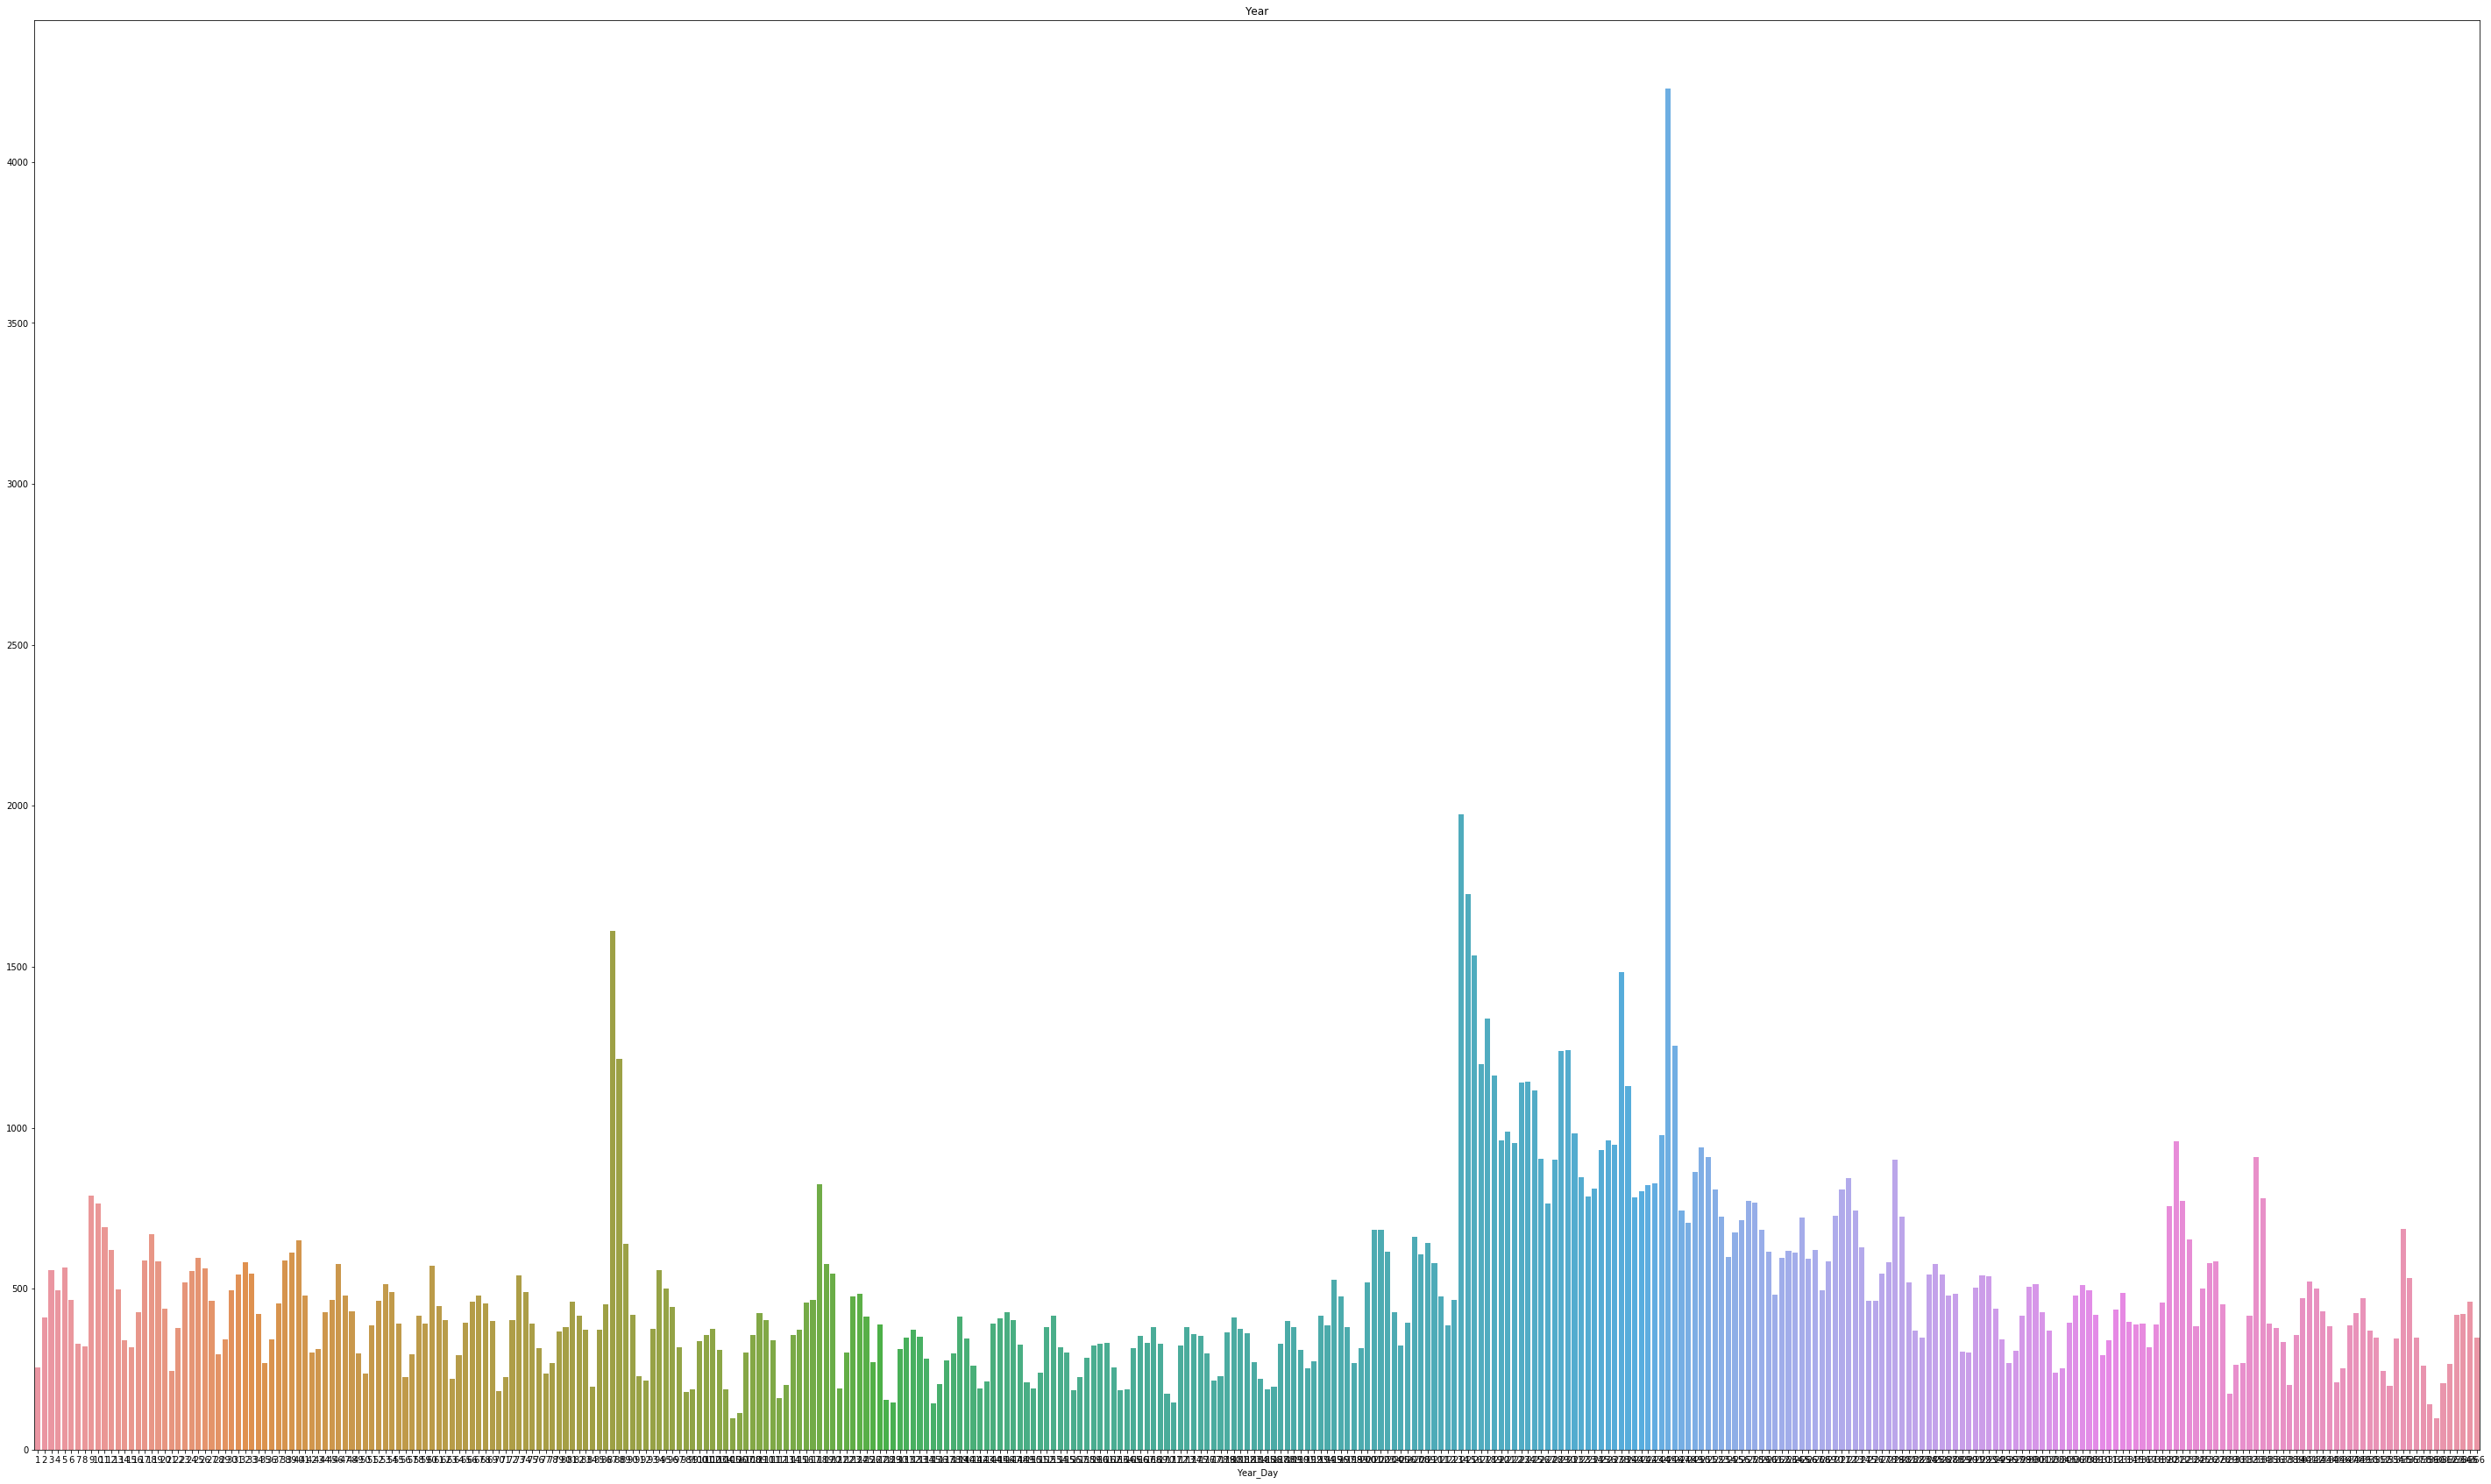

In [229]:
plt.figure(figsize=(50,30))
my_colors = 'rgbkymc'
sns.countplot(x='Year_Day',data=df)
plt.xlabel('Year_Day')
plt.ylabel('')
plt.title('Year')
plt.show()


In [ ]:
##Days of the month distribution

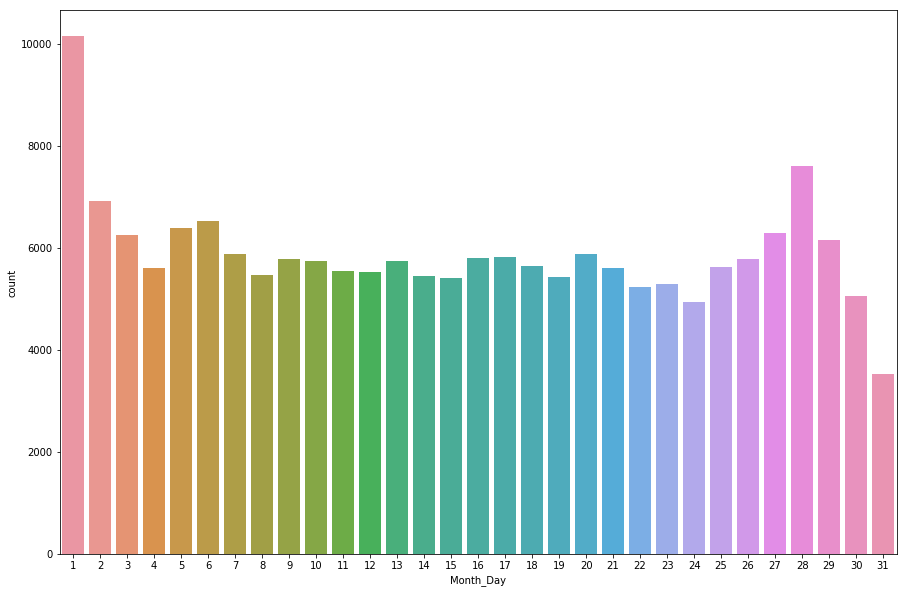

In [61]:
plt.figure(figsize=(15,10))
sns.countplot(x="Month_Day",data=df)

In [62]:
##1st day of the month has more requests

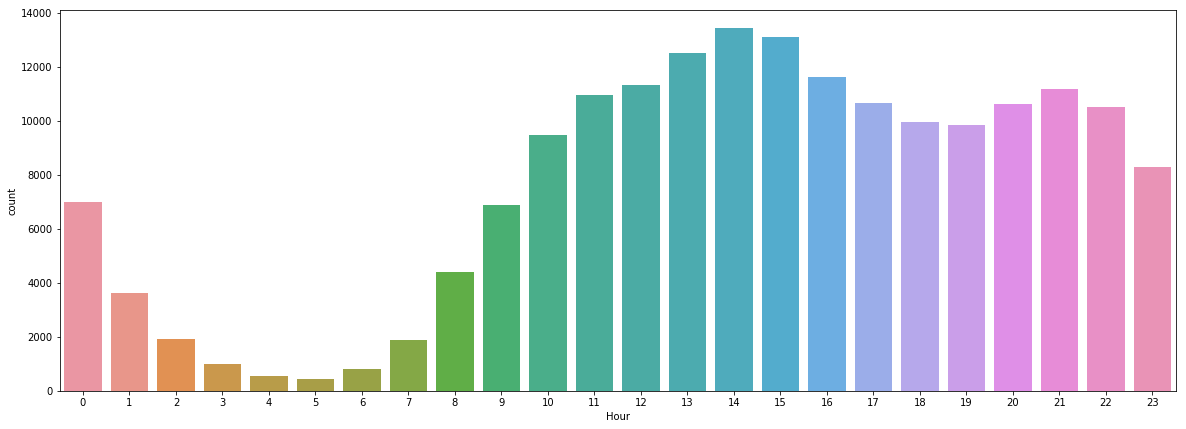

In [63]:
plt.figure(figsize=(20,7))
sns.countplot(x="Hour",data=df)

In [64]:
#At 14th hour of the day more requests have been made followed by 15th hour

In [232]:
#Are these features useful?We can do our analysis and if AUC>0.5 then they are useful towards final model

In [66]:
df.columns

Index(['id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'Year', 'Month', 'Weekday', 'Hour', 'Month_Day', 'Year_Day'],
      dtype='object')

In [67]:
df=df.sort_values(by=['project_submitted_datetime'])

In [ ]:
#We make a new df as DATEFRAME

In [68]:
Dateframe=df.drop(['id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],axis=1)

In [69]:
#Divding the Dateframe into train,test and cv

In [70]:
y=df['project_is_approved']

Datetrain=Dateframe.iloc[0:116532,:]
Datecvcv=Dateframe.iloc[116532:145664,:]
Datetest=Dateframe.iloc[145664:,:]


y_train=y[0:116532]
y_cv=y[116532:145664]
y_test=y[145664:]

In [71]:
#Applying Logistic Regression to see if the features are useful

In [74]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
alpha = [10 ** j for j in range(-5,1)] # hyperparam for SGD classifier.

cv_auc_array=[]
for i in alpha:
    clf = LogisticRegression(C=i, penalty='l2', random_state=42,class_weight='balanced')
    clf.fit(Datetrain, y_train)
    predict_y = clf.predict_proba(Datecvcv)[:,1]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_cv, predict_y)
    
    print('For values of alpha = ', i, "The AUC is:", auc(false_positive_rate, true_positive_rate))


For values of alpha =  1e-05 The AUC is: 0.4875786882206855
For values of alpha =  0.0001 The AUC is: 0.4877126646720637
For values of alpha =  0.001 The AUC is: 0.4877159861614708
For values of alpha =  0.01 The AUC is: 0.48771254812857573
For values of alpha =  0.1 The AUC is: 0.4877469673053561
For values of alpha =  1 The AUC is: 0.48809906460642644


In [75]:
clf =LogisticRegression(C=1, penalty='l2', random_state=42,class_weight='balanced')
clf.fit(Datetrain, y_train)

predict_y = clf.predict_proba(Datetrain)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_train,predict_y )
print('For values of best alpha = ',"The train AUC is:",metrics.auc(fpr, tpr))

predict_y = clf.predict_proba(Datecvcv)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_cv,predict_y )
print('For values of best alpha = ', "The cv AUC is:",metrics.auc(fpr, tpr))

predict_y = clf.predict_proba(Datetest)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,predict_y )
print('For values of best alpha = ', "The test AUC is:",metrics.auc(fpr, tpr))


For values of best alpha =  The train AUC is: 0.5121284767429721
For values of best alpha =  The cv AUC is: 0.48809906460642644
For values of best alpha =  The test AUC is: 0.5004210149521615


In [76]:
##I donot think think the features are more useful as AUC is 0.50
#Should we keep in the final model? We will see if they improve the final model

RESOURCE FEATURES


In [298]:
rc.head()

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [299]:
##below are 4 methods of histograms....please see and tell...i am confused

(array([2.6825e+04, 3.5000e+01, 1.0000e+01, 7.0000e+00, 5.0000e+00,
        2.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 2.98990e+03, 5.97880e+03, 8.96770e+03, 1.19566e+04,
        1.49455e+04, 1.79344e+04, 2.09233e+04, 2.39122e+04, 2.69011e+04,
        2.98900e+04]),
 <a list of 10 Patch objects>)

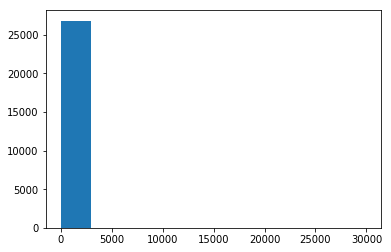

In [78]:
plt.hist(rc['price'].value_counts())
##if normed=True whats the difference

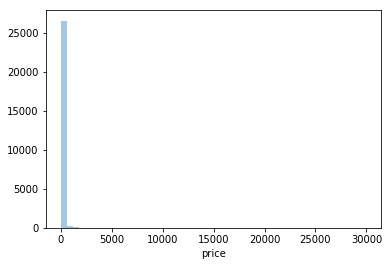

In [80]:
x=rc['price'].value_counts()
sns.distplot(x,kde=False)

In [81]:
## most of the prices list fall between 

In [82]:
rc['price'].value_counts().values

array([29890, 24729, 21408, ...,     1,     1,     1], dtype=int64)

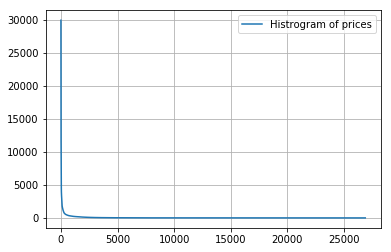

In [83]:
#s = sum(rc['price'].value_counts());
h = (rc['price'].value_counts().values); ## dont understand this line
plt.plot(h, label="Histrogram of prices")
plt.legend()
plt.grid()
plt.show()

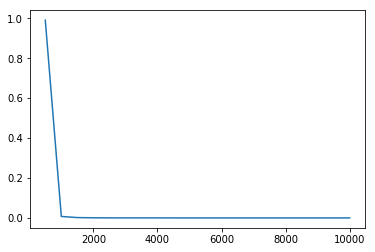

In [84]:
counts, bin_edges = np.histogram(rc['price'], bins=20, 
                                 density = True)

pdf = counts/(sum(counts))
plt.plot(bin_edges[1:],pdf);

plt.show();


In [85]:
## I could not understand what they have done here,but many notebook used it..so pls make it clear!

In [86]:
##Here, the resource dataset is delt with:

#Here the groupby function uses the .agg extension to compute multiple different descriptive statistics 
#for multiple different columns.


In [87]:
rc['total_price'] = rc['quantity']*rc['price']
agg_rc = rc.groupby('id').agg({'description':'count', 'quantity':'sum', 'price':'sum', 'total_price':'sum'}).rename(columns={'description':'items'})

for func in ['min', 'max', 'mean']:
    agg_rc_temp = rc.groupby('id').agg({'quantity':func, 'price':func, 'total_price':func}).rename(columns={'quantity':func+'_quantity', 'price':func+'_price', 'total_price':func+'_total_price'}).fillna(0)
    agg_rc = agg_rc.join(agg_rc_temp)

agg_rc = agg_rc.join(rc.groupby('id').agg({'description':lambda x:' '.join(x.values.astype(str))}).rename(columns={'description':'resource_description'}))

df = df.join(agg_rc, on='id')


In [88]:
df['resource_description'][0]

'Apple - iPod nano� 16GB MP3 Player (8th Generation - Latest Model) - Blue Apple - iPod nano� 16GB MP3 Player (8th Generation - Latest Model) - Silver'

In [89]:
#Are these features useful? Lets apply Logisticregression and see

In [90]:
df.columns

Index(['id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'Year', 'Month', 'Weekday', 'Hour', 'Month_Day', 'Year_Day', 'items',
       'quantity', 'price', 'total_price', 'min_quantity', 'min_price',
       'min_total_price', 'max_quantity', 'max_price', 'max_total_price',
       'mean_quantity', 'mean_price', 'mean_total_price',
       'resource_description'],
      dtype='object')

In [ ]:
##We make new dataframe as ResourceFrame

In [91]:
Resourceframe=df.drop(['id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved','Year', 'Month', 'Weekday', 'Hour', 'Month_Day',
                       'Year_Day','resource_description'],axis=1)

In [92]:
y=df['project_is_approved']

Restrain=Resourceframe.iloc[0:116532,:]
Rescv=Resourceframe.iloc[116532:145664,:]
Restest=Resourceframe.iloc[145664:,:]


y_train=y[0:116532]
y_cv=y[116532:145664]
y_test=y[145664:]

In [ ]:
#Applying Logistic Regression to see if resource features are useful

In [93]:
from sklearn import metrics
from sklearn.calibration import CalibratedClassifierCV
alpha = [10 ** j for j in range(-5,1)] # hyperparam for SGD classifier.

cv_auc_array=[]
for i in alpha:
    clf = LogisticRegression(C=i, penalty='l2', random_state=42,class_weight='balanced')
    clf.fit(Restrain, y_train)
    predict_y = clf.predict_proba(Rescv)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_cv,predict_y )
    cv_auc_array.append(metrics.auc(fpr, tpr))
    print('For values of alpha = ', i, "The AUC is:",metrics.auc(fpr, tpr))


For values of alpha =  1e-05 The AUC is: 0.6534432831792318
For values of alpha =  0.0001 The AUC is: 0.653234602352065
For values of alpha =  0.001 The AUC is: 0.6525188505207008
For values of alpha =  0.01 The AUC is: 0.6523757933892183
For values of alpha =  0.1 The AUC is: 0.652307052155231
For values of alpha =  1 The AUC is: 0.6523246696458289


In [94]:
clf =LogisticRegression(C=0.1, penalty='l2', random_state=42,class_weight='balanced')
clf.fit(Restrain, y_train)

predict_y = clf.predict_proba(Restrain)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_train,predict_y )
print('For values of best alpha = ',"The train AUC is:",metrics.auc(fpr, tpr))

predict_y = clf.predict_proba(Rescv)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_cv,predict_y )
print('For values of best alpha = ', "The cv AUC is:",metrics.auc(fpr, tpr))

predict_y = clf.predict_proba(Restest)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,predict_y )
print('For values of best alpha = ', "The test AUC is:",metrics.auc(fpr, tpr))


For values of best alpha =  The train AUC is: 0.666687166933135
For values of best alpha =  The cv AUC is: 0.652307052155231
For values of best alpha =  The test AUC is: 0.6631769271352979


In [95]:
##These features are totally useful and should be kept in the final model

Categorical features feature extraction

In [96]:
#Using only one hot encoding (Countvectorizer) and
#Response Coding

In [97]:
#dividing the whole data into train,cv and test as Xtrain,Xcv and Xtest

In [98]:
y=df['project_is_approved']
Xtrain=df.iloc[0:116532,:]
Xcv=df.iloc[116532:145664,:]
Xtest=df.iloc[145664:,:]


y_train=y[0:116532]
y_cv=y[116532:145664]
y_test=y[145664:]

In [99]:
##Code for response coding

In [100]:
#Response coding dictionary
def get_rs_fea_dict(alpha, df,feature):
    
    value_count = Xtrain[feature].value_counts()
    rs_dict = dict()
    
    
    for i, denominator in value_count.items():
       
        vec = []
        for k in range(0,2):
            

            cls_cnt =Xtrain.loc[(Xtrain['project_is_approved']==k) & (Xtrain[feature]==i)]
            
           
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 20*alpha))

       
        rs_dict[i]=vec
    return rs_dict

# Get Resonse Coding feature
def Res_feature(alpha,df, feature):
    
    rs_dict = get_rs_fea_dict(alpha,df, feature)
    
    value_count = Xtrain[feature].value_counts()
    
    
    Rs_fea = []
   
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            Rs_fea.append(rs_dict[row[feature]])
        else:
            Rs_fea.append([1/2,1/2])
#             
    return Rs_fea

In [101]:
X_1 =np.array(Res_feature(1,Xtrain, 'teacher_prefix'))
X_2 = np.array(Res_feature(1,Xtrain, 'school_state'))
X_3 = np.array(Res_feature(1,Xtrain, 'project_grade_category'))
X_4 =np.array( Res_feature(1,Xtrain, 'project_subject_categories'))
X_5 =np.array( Res_feature(1,Xtrain, 'project_subject_subcategories'))

cattrain =np.hstack((X_1, X_2, X_3, X_4, X_5))


In [102]:
X_1 =np.array(Res_feature(1,Xcv, 'teacher_prefix'))
X_2 = np.array(Res_feature(1,Xcv, 'school_state'))
X_3 = np.array(Res_feature(1,Xcv, 'project_grade_category'))
X_4 =np.array( Res_feature(1,Xcv, 'project_subject_categories'))
X_5 =np.array( Res_feature(1,Xcv, 'project_subject_subcategories'))

catcv = np.hstack((X_1, X_2, X_3, X_4, X_5))

In [103]:
X_1 =np.array(Res_feature(1,Xtest, 'teacher_prefix'))
X_2 = np.array(Res_feature(1,Xtest, 'school_state'))
X_3 = np.array(Res_feature(1,Xtest, 'project_grade_category'))
X_4 =np.array( Res_feature(1,Xtest, 'project_subject_categories'))
X_5 =np.array( Res_feature(1,Xtest, 'project_subject_subcategories'))

cattest =np.hstack((X_1, X_2, X_3, X_4, X_5))

In [ ]:
# This is the code for One hot encoding

In [ ]:
def getCatFeatures(df, Col):
    vectorizer = CountVectorizer(binary=True,
                                 ngram_range=(1,1),
                                 tokenizer=lambda x:[a.strip() for a in x.split(',')]) #why strip() is imp here?
    vectorizer.fit(df[Col])
   # return vectorizer.get_feature_names()

In [ ]:
X_tp = getCatFeatures(Xcv, 'teacher_prefix')
X_ss = getCatFeatures(Xcv, 'school_state')
X_pgc = getCatFeatures(Xcv, 'project_grade_category')
X_psc = getCatFeatures(Xcv, 'project_subject_categories')
X_pssc = getCatFeatures(Xcv, 'project_subject_subcategories')

#catcv = hstack((X_tp, X_ss, X_pgc, X_psc, X_pssc))


In [73]:
X_tp = getCatFeatures(Xtest, 'teacher_prefix')
X_ss = getCatFeatures(Xtest, 'school_state')
X_pgc = getCatFeatures(Xtest, 'project_grade_category')
X_psc = getCatFeatures(Xtest, 'project_subject_categories')
X_pssc = getCatFeatures(Xtest, 'project_subject_subcategories')

#cattest = hstack((X_tp, X_ss, X_pgc, X_psc, X_pssc))


In [233]:
cattrain.shape##100 featues 

(116532, 10)

In [423]:
##Applying Logistic Regression to only Response Coded features

In [104]:

alpha = [10 ** j for j in range(-5,1)] # hyperparam for SGD classifier.

cv_auc_array=[]
for i in alpha:
    clf = LogisticRegression(C=i, penalty='l2', random_state=42,class_weight='balanced')
    clf.fit(cattrain, y_train)
    predict_y = clf.predict_proba(catcv)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_cv,predict_y )
    cv_auc_array.append(metrics.auc(fpr, tpr))
    print('For values of alpha = ', i, "The AUC is:",metrics.auc(fpr, tpr))


For values of alpha =  1e-05 The AUC is: 0.5495038374662762
For values of alpha =  0.0001 The AUC is: 0.5489625415244448
For values of alpha =  0.001 The AUC is: 0.5490703539627738
For values of alpha =  0.01 The AUC is: 0.550434398369883
For values of alpha =  0.1 The AUC is: 0.5539850025624028
For values of alpha =  1 The AUC is: 0.5549472341588653


In [105]:
clf =LogisticRegression(C=1, penalty='l2', random_state=42,class_weight='balanced')
clf.fit(cattrain, y_train)

predict_y = clf.predict_proba(cattrain)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_train,predict_y )
print('For values of best alpha = ',"The train AUC is:",metrics.auc(fpr, tpr))

predict_y = clf.predict_proba(catcv)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_cv,predict_y )
print('For values of best alpha = ', "The cv AUC is:",metrics.auc(fpr, tpr))

predict_y = clf.predict_proba(cattest)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,predict_y )
print('For values of best alpha = ', "The test AUC is:",metrics.auc(fpr, tpr))


For values of best alpha =  The train AUC is: 0.5727882990935408
For values of best alpha =  The cv AUC is: 0.5549472341588653
For values of best alpha =  The test AUC is: 0.5748796095843418


In [106]:
###Definitely categorical features needs to be added to the final model

ID and Teacher ID

In [107]:
#Id and teacherID 
#no of previously applied feature is correlated with y,we can directly use this feature

In [108]:
df['id'][0:5]

128730    p146022
173035    p244738
7344      p070708
180523    p083729
8393      p205479
Name: id, dtype: object

In [109]:
df['teacher_id'][0:5]

128730    f91a89d2b72a0f5ee14cd98bd8741fc2
173035    64ef8a335f7206366c52c39f5bfd09b7
7344      1f802ff6be7973fb3624332e10549ed4
180523    f72fac3c6011b17ad5b2037dfd18cd0b
8393      2bf07ba08945e5d8b2a3f269b2b3cfe5
Name: teacher_id, dtype: object

In [ ]:
df['teacher_id']=le.fit_transform(df['id'])

In [ ]:
le = LabelEncoder()
le.fit(Xtrain['id'])
idtrain=le.transform(Xtrain['id'])
idcv=le.transform(Xcv['id'])
idtest=le.transform(Xtest['id'])

In [ ]:
##Label encoder is not helping 